<H1>CSPB 3022 Final Project</H1>
<H3>Michael Shippee</H3>
<H3>House Price Regression: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview </H3>

In [169]:
# First, get some libraries imported!
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import seaborn as sns
import sklearn.linear_model
import sklearn.model_selection
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor
%matplotlib inline

Problem: Given some data about houses, predict house prices based on a wide array of variables. Predictions should be as accurate as possible. In other words, my goal is to increase accuracy as much as possible while keeping as much data as possible and keeping things from running too slowly.

In [2]:
# Let's get some data frames started! Gonna need those.
df = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
pd.set_option("display.max_rows", None, "display.max_columns", None)
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
#let's look at dimensions, because that's how we roll!
print('Rows:', df.shape[0], 'Columns:', df.shape[1])

Rows: 1460 Columns: 81


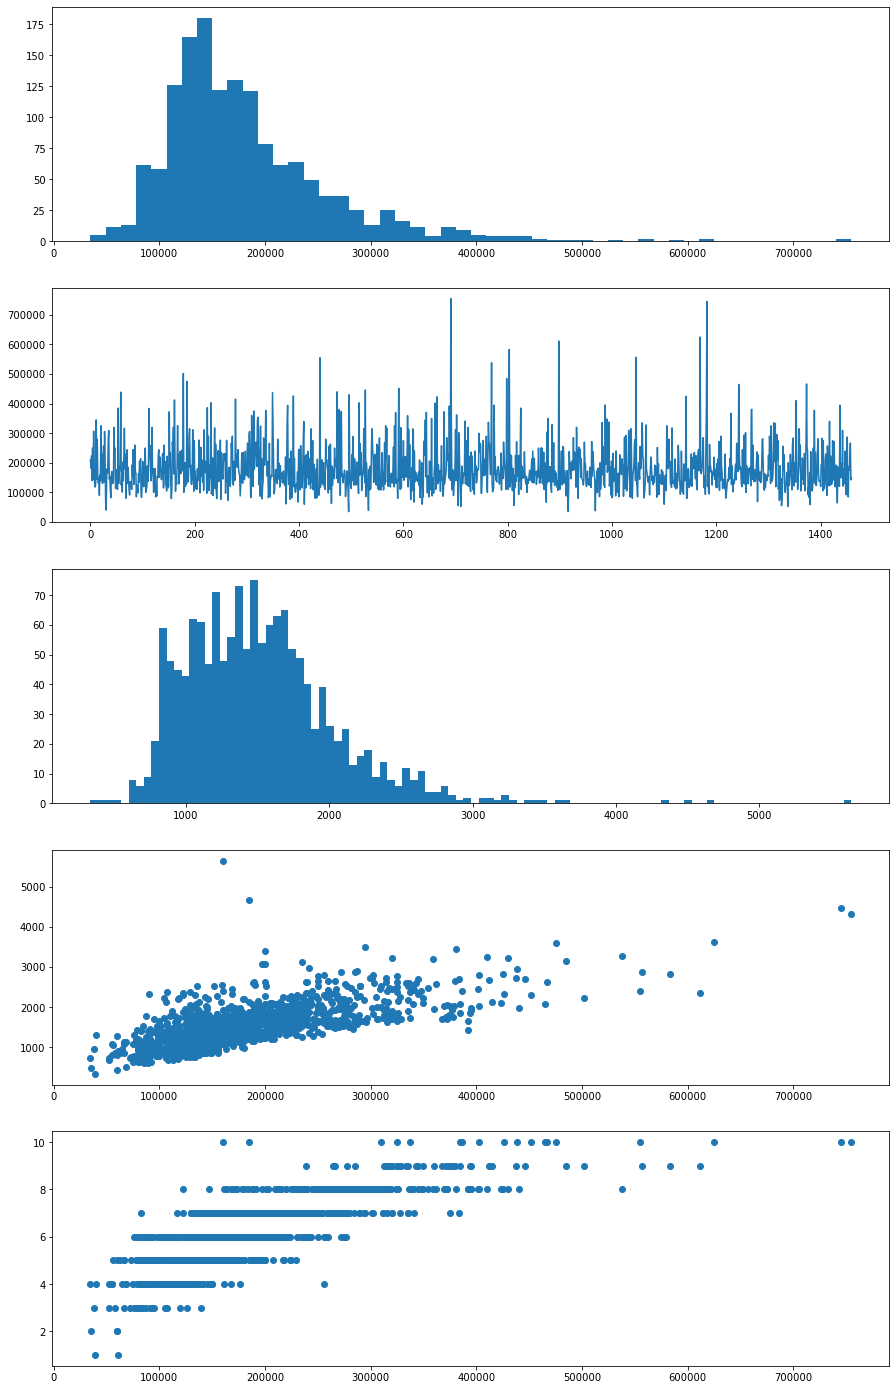

In [4]:
# Graphs and charts are awesome. Let's build graphs and charts!
fig, axs = plt.subplots(5, figsize=(15,25))
axs[0].hist(df['SalePrice'], bins=50);
axs[1].plot(df['SalePrice']);
axs[2].hist(df['GrLivArea'], bins=100);
axs[3].scatter(x=df['SalePrice'], y=df['GrLivArea']);
axs[4].scatter(x=df['SalePrice'], y=df['OverallQual']);

We see in the first and second graphs that most of the house prices are between 100,000 and 200,000. The second graph and the first graph both show that above 400,000 and below 50,000 the number of houses becomes increasingly small. This tracks with what we would expect. The third graph shows that the majority of the living areas (what I expect will have the largest impact on sale price) are centered around 1,500. 

There are two values of GrLivArea that appear to be outliers in the 4th graph. These are properties with very high living areas, but with low cost. The two values with sales prices over 700,000 appear to maintain linearity with the rest of the graph.

We need to clean up the data a little bit and then look at a Pair Plot.

In [5]:
# investigate columns with high percentages of NaN
for col in df.columns:
    if df[f'{col}'].isnull().sum() >= (.1 * df.shape[0] ):
        print(col, ':', df[f'{col}'].isnull().sum())
        


LotFrontage : 259
Alley : 1369
FireplaceQu : 690
PoolQC : 1453
Fence : 1179
MiscFeature : 1406


These are the columns that have more than 10% NaN values. Looking at these columns, the data description tells us that for most of these columns, the NA value means that there is no feature of that type. For example, an NA value in Alley means 'no alley access'. 

For these sorts of columns, it makes sense to replace the values with 0 in numerical columns, and "None" in string columns. This includes Alley, FireplaceQu, PoolQC, and Fence. 

LotFrontage has a high number of NaN instances, but it it clearly less than the rest. There is also no explanation in the description for what a NaN value means here. I will include this column, but will have to replace the NaN values and then I will be sure to have it impact the regression model less than the other columns.

The only column left is MiscFeature. I will be removing this column because there is another column, "MiscValue", that seems like it will be a much better indicator for the Sales Value of the house. This is largely due to the presence of one value type in MiscValue, "Other". Since we are not sure what these features are, we should just look at the MiscValue column.

All columns will need NaN values replaced. I will do one column per cell so that it can be run in different cells and not all at once. I will comment in each cell why I am using a particular strategy for that particular column (or columns, if the situation warrants it.) It is worth noting that the 'Neighborhood' column immediately looks like a good way to group certain entries together in order to give them similar values.

In [6]:
# as explained above, we will drop MiscFeature
df2 = df.drop('MiscFeature', axis=1)
df_test = df_test.drop('MiscFeature', axis=1)

In [7]:
# First we need to get a list of columns that have null values
has_null = []
for col in df2.columns:
    if df2[f'{col}'].isna().sum() > 0:
        has_null.append(col)
print(has_null)

['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence']


In [8]:
# LotFrontage - we will replace NaN with 0, assuming this means no street frontage
df2['LotFrontage'].fillna(0, inplace=True);
df_test['LotFrontage'].fillna(0, inplace=True);

In [9]:
# Alley - we will replace NaN with 'None'
df2['Alley'].fillna('None', inplace=True);
df_test['Alley'].fillna('None', inplace=True);

In [10]:
# MasVnrType - there is already a 'None' category in this filing. We will fill with this. We will also do all 
# columns that have to do with veneer
df2['MasVnrType'].fillna('None', inplace=True);
df2['MasVnrArea'].fillna(0, inplace=True);
df_test['MasVnrType'].fillna('None', inplace=True);
df_test['MasVnrArea'].fillna(0, inplace=True);

In [11]:
# Basement columns can all be done in this cell
# BsmtQual - NA values should be None as per description
df2['BsmtQual'].fillna('None', inplace=True);
df2['BsmtCond'].fillna('None', inplace=True);
df2['BsmtExposure'].fillna('None', inplace=True);
df2['BsmtFinType1'].fillna('None', inplace=True);
df2['BsmtFinType2'].fillna('None', inplace=True);
df_test['BsmtQual'].fillna('None', inplace=True);
df_test['BsmtCond'].fillna('None', inplace=True);
df_test['BsmtExposure'].fillna('None', inplace=True);
df_test['BsmtFinType1'].fillna('None', inplace=True);
df_test['BsmtFinType2'].fillna('None', inplace=True);

In [12]:
# Electrical - there is only 1 NaN value in this column. I will just swap it with the most common value - SBrkr
df2['Electrical'].fillna('SBrkr', inplace=True);
df_test['Electrical'].fillna('SBrkr', inplace=True);

In [13]:
# FireplaceQu - NaN means none
df2['FireplaceQu'].fillna('None', inplace=True);
df_test['FireplaceQu'].fillna('None', inplace=True);

In [14]:
# Garage columns, NaN will mean there is no garage
df2['GarageType'].fillna('None', inplace=True);
df2['GarageYrBlt'].fillna(0, inplace=True);
df2['GarageFinish'].fillna('None', inplace=True);
df2['GarageQual'].fillna('None', inplace=True);
df2['GarageCond'].fillna('None', inplace=True);

df_test['GarageType'].fillna('None', inplace=True);
df_test['GarageYrBlt'].fillna(0, inplace=True);
df_test['GarageFinish'].fillna('None', inplace=True);
df_test['GarageQual'].fillna('None', inplace=True);
df_test['GarageCond'].fillna('None', inplace=True);

In [15]:
# PoolQC - NaN means no pool
df2['PoolQC'].fillna('None', inplace=True);
df_test['PoolQC'].fillna('None', inplace=True);

In [16]:
# Fence - NaN means no fence
df2['Fence'].fillna('None', inplace=True);
df_test['Fence'].fillna('None', inplace=True);

In [17]:
# after filling these, let's check all of the columns to see if any are just the same value over and over.
# Such a trend would mean that these columns are useless. Anything column where one value represents more than
# 95% of total values will be removed.
for col in df2.columns:
    if col != 'Id' and col != 'LotArea' and col != 'LotFrontage':
        print(col, df2[f'{col}'].value_counts(normalize=True))


censored for brevity

In [18]:
# remove the columns that the above cell highlights 
df3 = df2.drop(['Street','Utilities','LandSlope','Condition2','RoofMatl','Heating','LowQualFinSF','KitchenAbvGr','3SsnPorch','PoolArea','PoolQC','MiscVal'], axis = 1)
df_test.drop(['Street','Utilities','LandSlope','Condition2','RoofMatl','Heating','LowQualFinSF','KitchenAbvGr','3SsnPorch','PoolArea','PoolQC','MiscVal'], axis = 1, inplace=True)


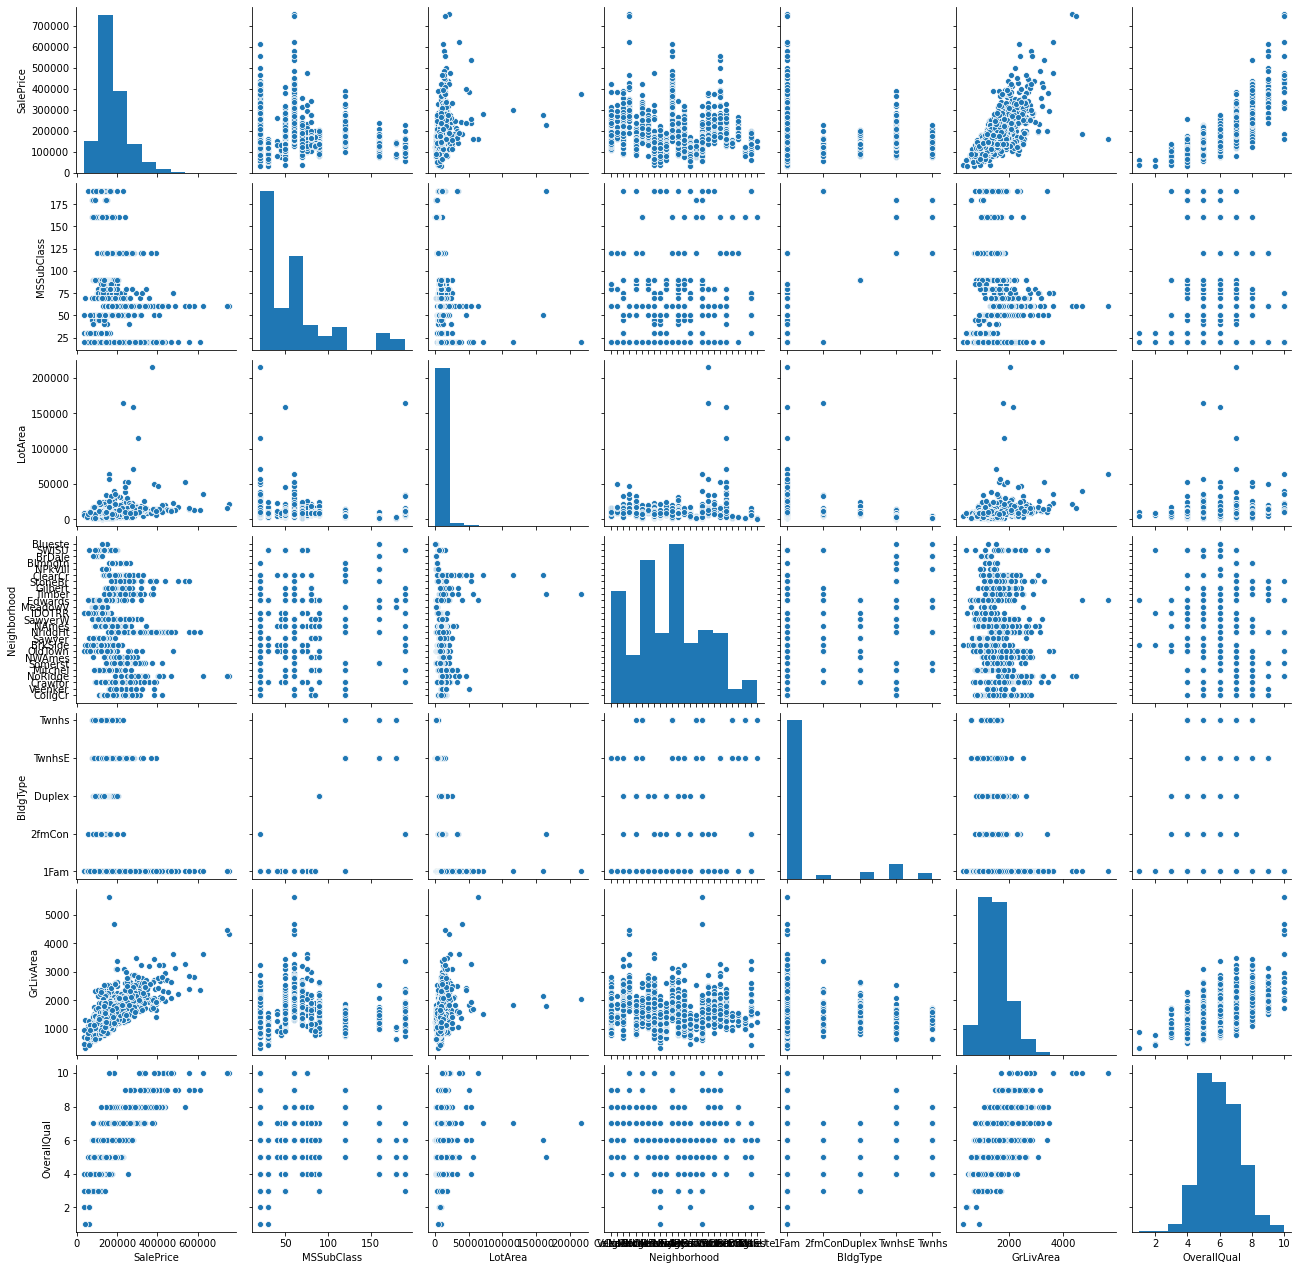

In [19]:
# time to look at a pair plot and some qqplots!
sns.pairplot(df3, vars=['SalePrice', 'MSSubClass', 'LotArea', 'Neighborhood', 'BldgType', 'GrLivArea', 'OverallQual'])

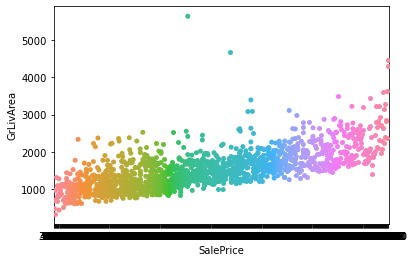

In [20]:
sns.stripplot(x='SalePrice', y='GrLivArea', data=df3, jitter=True);

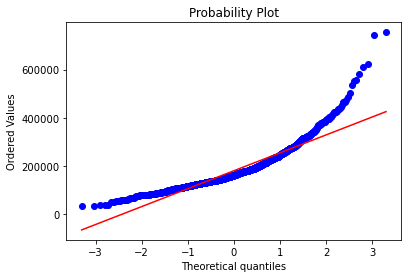

In [21]:
stats.probplot(df3['SalePrice'], plot=plt);

QQ plot indicates that as houses get less expensive, they don't decrease in price as quickly as the probability suggests. Likewise is true for house price as they get more and more expensive.

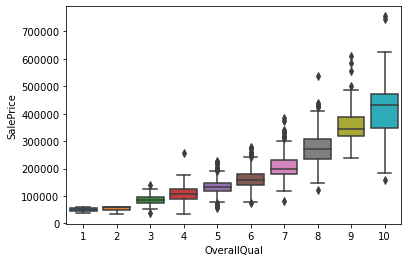

In [22]:
sns.boxplot(x = 'OverallQual', y = 'SalePrice', data = df3);

This box plot shows a clear trend between sale price and the overall quality of the property.

Next I will look at a correlation table for SalePrice, and drop columns with below a .25 correlation.

In [23]:
corr = df3.corr()
corr['SalePrice'].sort_values()

EnclosedPorch   -0.128578
MSSubClass      -0.084284
OverallCond     -0.077856
YrSold          -0.028923
Id              -0.021917
BsmtHalfBath    -0.016844
BsmtFinSF2      -0.011378
MoSold           0.046432
ScreenPorch      0.111447
BedroomAbvGr     0.168213
LotFrontage      0.209624
BsmtUnfSF        0.214479
BsmtFullBath     0.227122
GarageYrBlt      0.261366
LotArea          0.263843
HalfBath         0.284108
OpenPorchSF      0.315856
2ndFlrSF         0.319334
WoodDeckSF       0.324413
BsmtFinSF1       0.386420
Fireplaces       0.466929
MasVnrArea       0.472614
YearRemodAdd     0.507101
YearBuilt        0.522897
TotRmsAbvGrd     0.533723
FullBath         0.560664
1stFlrSF         0.605852
TotalBsmtSF      0.613581
GarageArea       0.623431
GarageCars       0.640409
GrLivArea        0.708624
OverallQual      0.790982
SalePrice        1.000000
Name: SalePrice, dtype: float64

In [24]:
df4 = df3.drop(['BsmtFullBath', 'BsmtUnfSF', 'LotFrontage', 'BedroomAbvGr', 'ScreenPorch', 'MoSold', 'BsmtFinSF2', 'YrSold', 'OverallCond', 'MSSubClass', 'EnclosedPorch', 'BsmtHalfBath'], axis=1)
df_test2 = df_test.drop(['BsmtFullBath', 'BsmtUnfSF', 'LotFrontage', 'BedroomAbvGr', 'ScreenPorch', 'MoSold', 'BsmtFinSF2', 'YrSold', 'OverallCond', 'MSSubClass', 'EnclosedPorch', 'BsmtHalfBath'], axis=1)

We should use the columns that had the highest correlation to build our model and apply our regression. Those columns are:<br>
YearRemodAdd     0.507101<br>
YearBuilt        0.522897<br>
TotRmsAbvGrd     0.533723<br>
FullBath         0.560664<br>
1stFlrSF         0.605852<br>
TotalBsmtSF      0.613581<br>
GarageArea       0.623431<br>
GarageCars       0.640409<br>
GrLivArea        0.708624<br>
OverallQual      0.790982<br>

One potential problem that I predict popping up is that using these columns effectively excludes non-numerical values from having an impact. The type of house (2 story family vs townhouse) would surely have an effect, but I am hoping that the impact of these categorical values is born out by the quantitative values of the columns I will be using.

In [74]:
use_cols = ['YearRemodAdd', 'YearBuilt', 'TotRmsAbvGrd', 'FullBath', '1stFlrSF', 'TotalBsmtSF', 'GarageArea', 'GarageCars', 'GrLivArea', 'OverallQual']

use_df_tr = pd.DataFrame(columns=use_cols, index=df3['Id'])
use_df_te = pd.DataFrame(columns=use_cols)
for i in use_cols:
    use_df_tr[f'{i}'] = df4[f'{i}']
    use_df_te[f'{i}'] = df_test2[f'{i}']

Next it is time to built a prediction model, apply some regression, and then start predicting. Yay!

In [201]:
train = use_df_tr
test = use_df_te
sales = df4['SalePrice']
display(train.head())
display(test.head())

,YearRemodAdd,YearBuilt,TotRmsAbvGrd,FullBath,1stFlrSF,TotalBsmtSF,GarageArea,GarageCars,GrLivArea,OverallQual
Id,,,,,,,,,,
1,2003,2003,8,2,856,856,548,2,1710,7
2,1976,1976,6,2,1262,1262,460,2,1262,6
3,2002,2001,6,2,920,920,608,2,1786,7
4,1970,1915,7,1,961,756,642,3,1717,7
5,2000,2000,9,2,1145,1145,836,3,2198,8


,YearRemodAdd,YearBuilt,TotRmsAbvGrd,FullBath,1stFlrSF,TotalBsmtSF,GarageArea,GarageCars,GrLivArea,OverallQual
Id,,,,,,,,,,
1461,1961,1961,5,1,896,882.0,730.0,1.0,896,5
1462,1958,1958,6,1,1329,1329.0,312.0,1.0,1329,6
1463,1998,1997,6,2,928,928.0,482.0,2.0,1629,5
1464,1998,1998,7,2,926,926.0,470.0,2.0,1604,6
1465,1992,1992,5,2,1280,1280.0,506.0,2.0,1280,8


In [76]:
train.set_index('Id',inplace = True)
test.set_index('Id',inplace = True)
#Below error is because I tried to run this twice. The Id is already set, but now is no longer in these tables.

KeyError: "None of ['Id'] are in the columns"

In [202]:
x_train = np.array(train)
x_test = np.array(test)
y_train = np.array(sales)

Data's all split up into variables. We now need to select and build a regression model. After some research, it appears that scaled Gradient Boosting Regressors (in the sklearn library) work best for this problem. The regression techniques we learned in class do not appear well suited to the many different variables present here. Lasso-ing should be applied if GBR does not appear to work.

In [203]:
gbr = GradientBoostingRegressor(n_estimators=250, min_samples_split = 2, min_samples_leaf=1)
gbr.fit(x_train, y_train)

x_test = np.nan_to_num(x_test)
Y_pred = gbr.predict(x_test)

submission = pd.DataFrame(index=test.index)
submission['SalePrice']=Y_pred

In [204]:
print(submission.shape)

(1459, 1)


In [205]:
submission.head()

,SalePrice
Id,
1461,126076.865891
1462,143516.402112
1463,164342.387990
1464,180618.103380
1465,199614.289699


In [192]:
submission.to_csv("mship.csv")

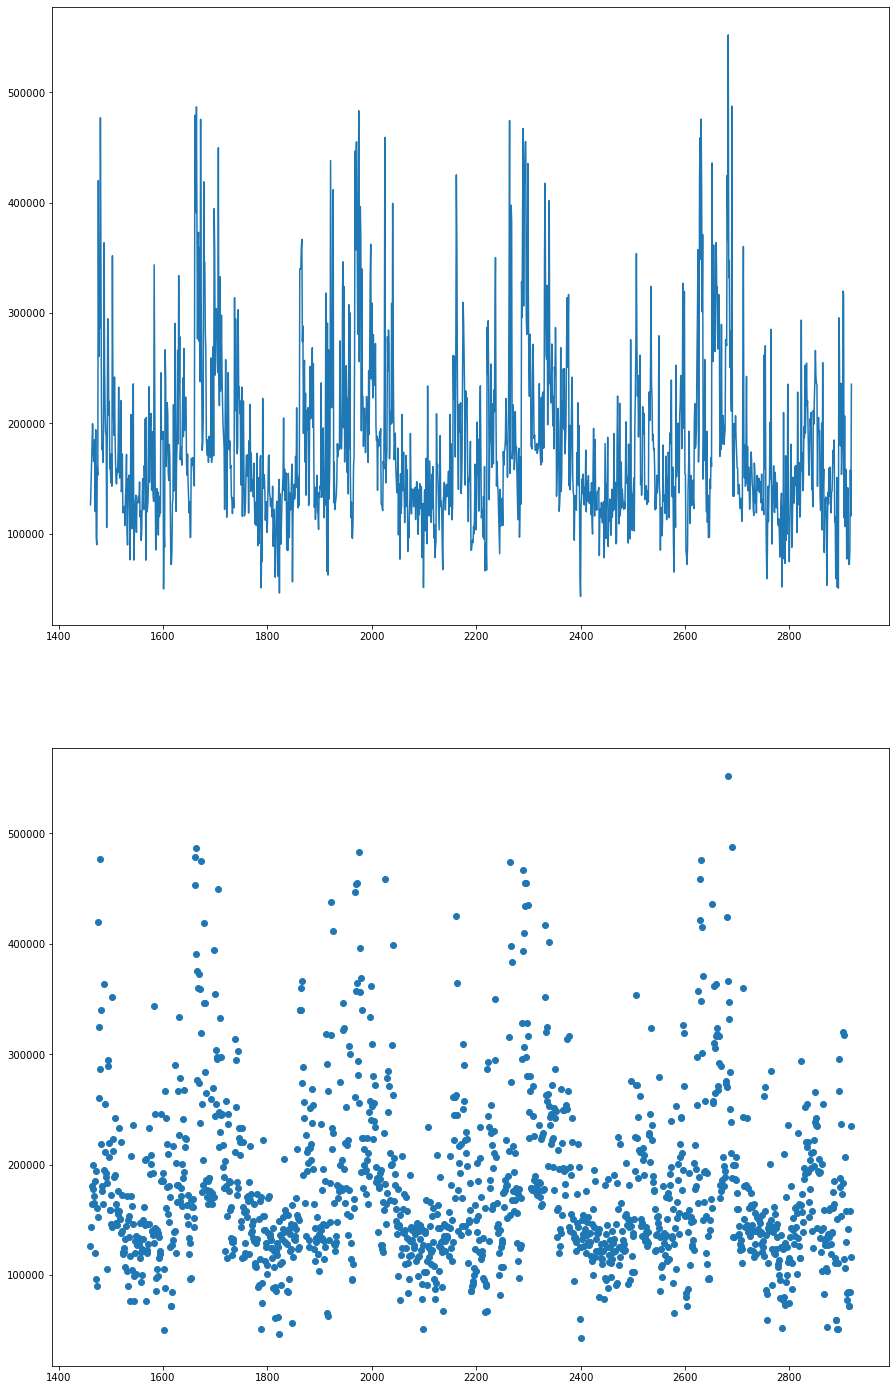

In [200]:
fig, axs = plt.subplots(2, figsize=(15,25))
axs[0].plot(submission);
axs[1].scatter(submission.index, submission['SalePrice']);

When compared to our first plot of the data, this one appears to have too many scores over 400,000. My final score on Kaggle was .156 - this placed me roughly in the middle of the pack for all teams. I suspect that some more feature engineering (combining some columns and looking more into how the different non-SalePrice columns correlate) would improve my score. 

The scatter plot also makes it seem as though there is some issue with the indexing. The data does not seem as randomly distributed as I would expect. This could be due to the table that is being tested, though, and is not necessarily problematic.

All in all, I really enjoyed this project and the freewheeling nature of it. It was nice to be able to just work on something without a direct method being prescribed.

To whoever has to read through this to evaluate: I hope you have a very nice holiday break. You're amazing.